# Relative Collision Risk NYC Traffic and Traffic Extrapolation

In [84]:
import numpy as np 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
from shapely import wkt
import matplotlib.pyplot as plt

In [85]:
streets = gpd.GeoDataFrame.from_file('geo_export_ccfbdf2d-83b4-4827-a495-e26464c3c50b.shp')

In [86]:
streets = gpd.GeoDataFrame.from_file('geo_export_ccfbdf2d-83b4-4827-a495-e26464c3c50b.shp')
traffic = pd.read_csv('traffic_matched.csv')
traffic = traffic.dropna(subset = ['geometry'])
traffic['geometry'] = traffic['geometry'].astype(str).apply(wkt.loads)
traffic = pd.melt(traffic, id_vars=['Date', 'geometry', 'streetID'], value_vars=list(traffic.columns[7:31]),
        var_name='time', value_name='traffic')
traffic = gpd.GeoDataFrame(traffic, geometry = 'geometry')

C:\Users\Andy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31,32,33,34,36,37,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
traffic['area'] = traffic['geometry'].area
traffic = traffic[traffic['area']<2e-5]

In [88]:
traffic['start_time'] = traffic['time'].str[:2]
traffic['start_time'] = traffic['start_time'].str.replace(':', '')
traffic['start_time'] = pd.to_numeric(traffic['start_time'])
traffic['start_time'] = np.where(traffic['time'].str[-2:] == 'PM', traffic['start_time']+12, traffic['start_time'])
traffic['start_time'] = np.where(traffic['time']=='11:00-12:00AM', 23, traffic['start_time'])
traffic['start_time'] = np.where(traffic['time']=='11:00-12:00PM', 11, traffic['start_time'])

In [89]:
traffic['Date_f'] = traffic['Date'].str[-4:] + '-' + traffic['Date'].str[:2] + '-' + traffic['Date'].str[-7:-5]   #.sort_values().unique()
traffic['Date_f'] = pd.to_datetime(traffic['Date_f'])
traffic

,Date,geometry,streetID,time,traffic,area,start_time,Date_f
0,01/09/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,20.0,7.116706e-07,12,2012-01-09
1,01/10/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,21.0,7.116706e-07,12,2012-01-10
2,01/11/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,27.0,7.116706e-07,12,2012-01-11
3,01/12/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,22.0,7.116706e-07,12,2012-01-12
4,01/13/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,31.0,7.116706e-07,12,2012-01-13
...,...,...,...,...,...,...,...,...
330667,03/25/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,120.0,2.577393e-07,23,2017-03-25
330668,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,92.0,5.300767e-08,23,2017-03-26
330669,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,83.0,5.300767e-08,23,2017-03-26
330670,03/26/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,86.0,2.577393e-07,23,2017-03-26


In [90]:
traffic['end_time'] = traffic['time'].str[-7:-2]
traffic['end_time'] = traffic['end_time'].str.replace(':', '')
traffic['end_time'] = traffic['end_time'].str.replace('-', '')
traffic['end_time'] = pd.to_numeric(traffic['end_time'])
traffic['end_time'] = np.where(traffic['time'].str[-2:] == 'PM', traffic['end_time']+12, traffic['end_time'])
traffic['end_time'] = np.where(traffic['time']=='11:00-12:00AM', 0, traffic['end_time'])
traffic['end_time'] = np.where(traffic['time']=='11:00-12:00PM', 12, traffic['end_time'])

In [ ]:
### Model Based Imputation
### Make smooth by making all from pmf of weekend or weekday of a month

In [ ]:
'''
def impute_traffic_hourwise_forward(row):
    if row['traffic'] != np.nan:
        return row
    elif row['hour'] != 0:
        return traffic[(traffic['streedID'] == row['streetID']) & (traffic['hour'] == row['hour'] - 1) & (traffic['Date'] == row['Date'])]
    else:
        return traffic[(traffic['streedID'] == row['streetID']) & (traffic['hour'] == 23) & (traffic['Date'] == row['Date']-1)]
    
def impute_traffic_hourwise_backward(row):
    if row['traffic'] != np.nan:
        return row
    elif row['hour'] != 23:
        return traffic[(traffic['streedID'] == row['streetID']) & (traffic['hour'] == row['hour'] + 1) & (traffic['Date'] == row['Date'])]
    else:
        return traffic[(traffic['streedID'] == row['streetID']) & (traffic['hour'] == 0) & (traffic['Date'] == row['Date']+1)]
    
def impute_traffic_daywise_forward(row):
    if row['traffic'] != np.nan:
        return row
    elif row['dayofweek'] != 'Saturday' and row['dayofweek'] != 'Monday':
        return traffic[(traffic['streetID'] == row['streetID'])&(traffic['hour'] == row['hour'])&(traffic['Date'] == row['Date']-1)]
    else:
        return row
    
def impute_traffic_daywise_backward(row):
    if row['traffic'] != np.nan:
        return row
    elif row['dayofweek'] != 'Friday' and row['dayofweek'] != 'Sunday':
        return traffic[(traffic['streetID'] == row['streetID'])&(traffic['hour'] == row['hour'])&(traffic['Date'] == row['Date']+1)]
    else:
        return row
    
'''

In [91]:
collisions = pd.read_csv('collisions_matched.tsv', sep = "\t")
collisions['hour'] = collisions['CRASH TIME'].str[:2]
collisions['hour'] = pd.to_numeric(collisions['hour'].str.replace(':', ''))

C:\Users\Andy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [104]:
tc = pd.merge(traffic, collisions, how = 'left', left_on = ['streetID', 'start_time', 'Date'], right_on = ['streetID', 'hour', 'CRASH DATE'])
tc

,Date,geometry,streetID,time,traffic,area,start_time,Date_f,end_time,collision_id,...,int2,zip1,zip2,ll1,ll2,lat1,long1,lat2,long2,hour
0,01/09/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,20.0,7.116706e-07,12,2012-01-09,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/10/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,21.0,7.116706e-07,12,2012-01-10,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/11/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,27.0,7.116706e-07,12,2012-01-11,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/12/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,22.0,7.116706e-07,12,2012-01-12,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/13/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,31.0,7.116706e-07,12,2012-01-13,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329042,03/25/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,120.0,2.577393e-07,23,2017-03-25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329043,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,92.0,5.300767e-08,23,2017-03-26,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329044,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,83.0,5.300767e-08,23,2017-03-26,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329045,03/26/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,86.0,2.577393e-07,23,2017-03-26,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Relative Risk All Time

In [105]:
by_street = tc[['streetID', 'area','traffic', 'collision_id','geometry']].groupby(by = 'streetID',
                                                                                  as_index = False).agg({'area':['first'],
                                                                                                         'traffic':['sum'],
                                                                                                         'collision_id':['count'],
                                                                                                         'geometry':['first']})
by_street.columns = ['streetID', 'area', 'traffic', 'collisions', 'geometry']
by_street['risk_rate'] = by_street['collisions'] / by_street['traffic']
by_street

,streetID,area,traffic,collisions,geometry,risk_rate
0,0.0,4.319897e-07,158478.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.000000
1,1.0,7.942584e-07,188888.0,1,"POLYGON ((-73.93189 40.80105, -73.93188 40.801...",0.000005
2,2.0,2.552392e-07,403577.0,0,"POLYGON ((-73.98317 40.73072, -73.98316 40.730...",0.000000
3,3.0,2.511981e-07,217731.0,0,"POLYGON ((-73.97679 40.73948, -73.97679 40.739...",0.000000
4,4.0,5.300767e-08,199442.0,0,"POLYGON ((-73.96093 40.76087, -73.96093 40.760...",0.000000
...,...,...,...,...,...,...
919,2431.0,3.626777e-07,224437.0,0,"POLYGON ((-74.14048 40.60446, -74.14048 40.604...",0.000000
920,2434.0,5.300767e-08,184703.0,0,"POLYGON ((-73.95220 40.76882, -73.95220 40.768...",0.000000
921,2440.0,2.433229e-07,54895.0,0,"POLYGON ((-73.84355 40.82624, -73.84355 40.826...",0.000000
922,2441.0,5.300767e-08,159143.0,0,"POLYGON ((-73.84363 40.82774, -73.84363 40.827...",0.000000


C:\Users\Andy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Andy\anaconda3\lib\site-packages\matplotlib\colors.py:972: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
C:\Users\Andy\anaconda3\lib\site-packages\matplotlib\colors.py:973: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
C:\Users\Andy\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


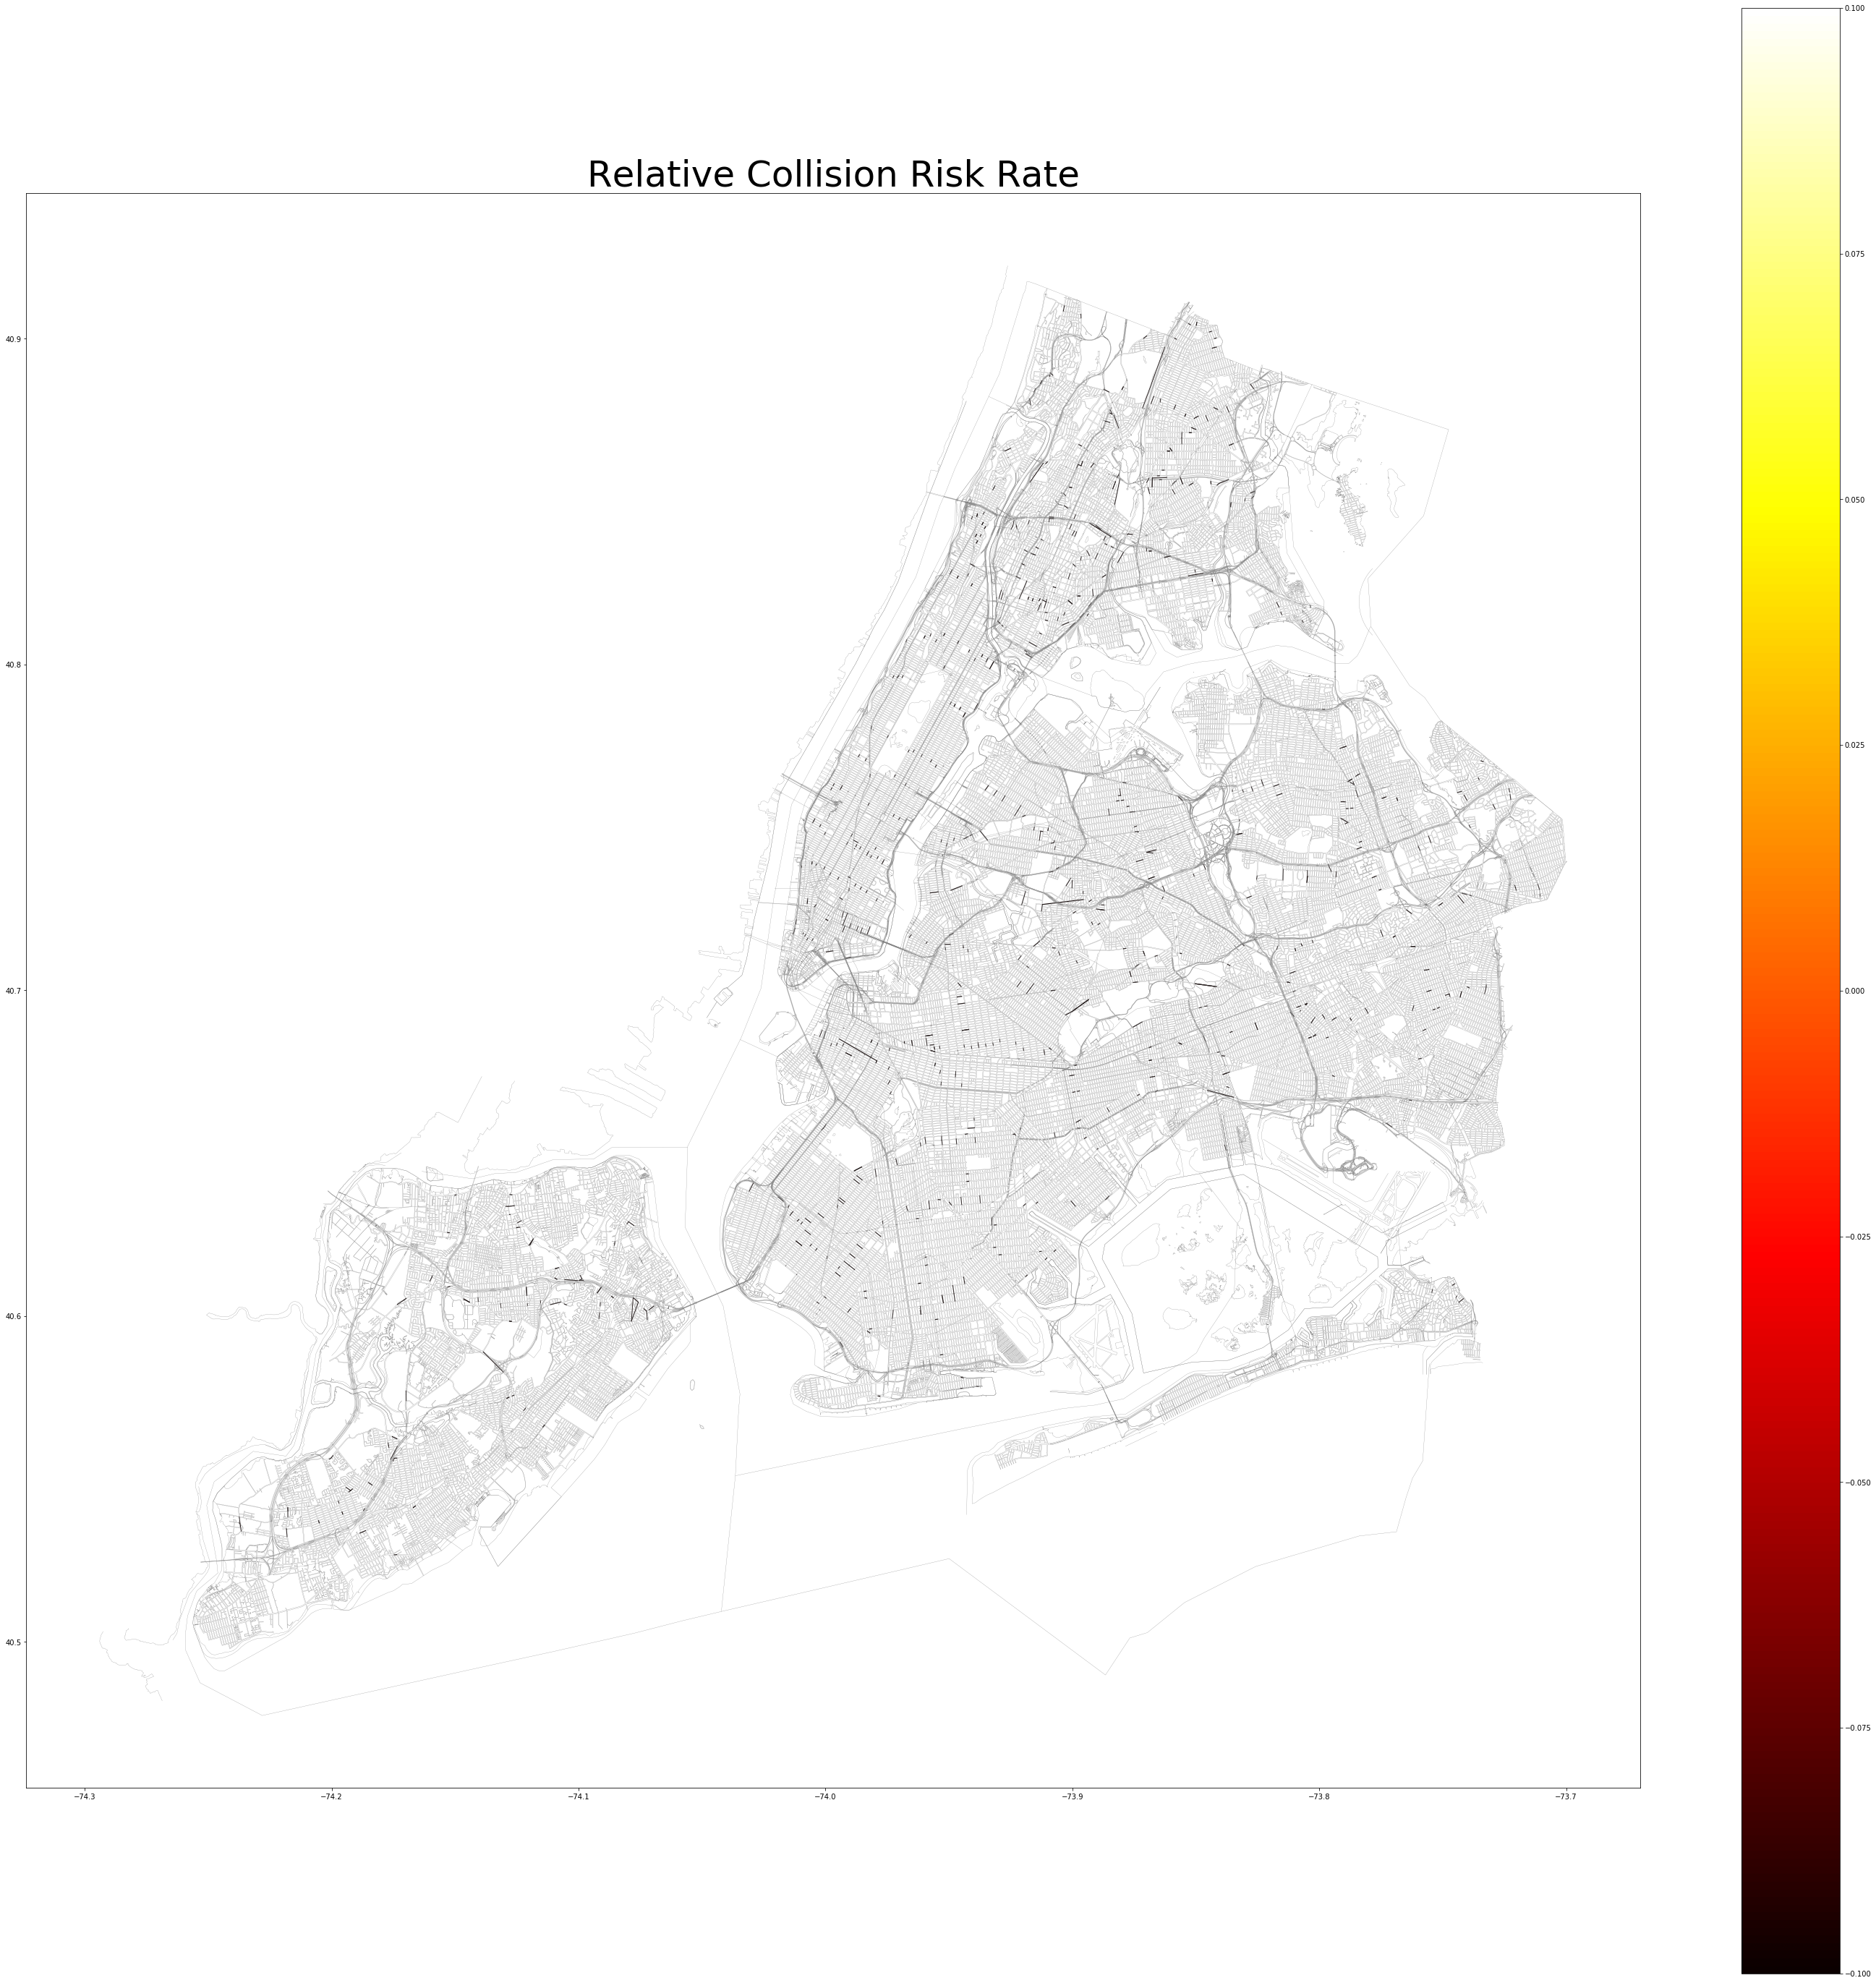

In [106]:
fig, ax = plt.subplots(figsize = (50, 50))
by_street['log_risk_rate'] = np.log(by_street['risk_rate'])
by_street = gpd.GeoDataFrame(by_street, geometry = 'geometry')
by_street = by_street.set_crs(4326, allow_override = True)
streets.to_crs(by_street.crs).plot(ax=ax, figsize = (50, 50), color = 'grey', linewidth = 0.25)
by_street.plot(column = 'log_risk_rate', ax=ax, figsize = (50, 50), cmap = 'hot', linewidth = 10, legend = True)
plt.title('Relative Collision Risk Rate', fontsize = 50)
fig.show()

### Relative Risk by Hour

In [107]:
by_hour = tc[['start_time', 'traffic', 'collision_id']].groupby(by = ['start_time'],
                                                                                  as_index = False).agg({'traffic':['sum'],
                                                                                                         'collision_id':['count']})
by_hour.columns = ['start_time', 'traffic', 'collisions']
by_hour['risk_rate'] = by_hour['collisions'] / by_hour['traffic']

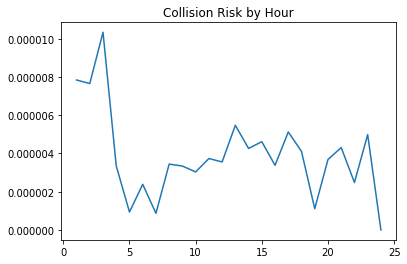

In [108]:
plt.plot(by_hour['start_time'], by_hour['risk_rate'])
plt.title('Collision Risk by Hour')
plt.show()

### Relative Risk Over Time

In [112]:
by_day = tc[['Date_f', 'traffic', 'collision_id']].groupby(by = ['Date_f'],as_index = False).agg({'traffic':['sum'],
                                                                                               'collision_id':['count']})
by_day.columns = ['Date', 'traffic', 'collisions']
by_day['risk_rate'] = by_day['collisions'] / by_day['traffic']

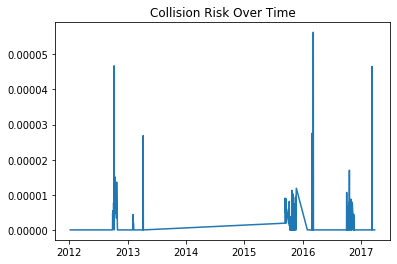

In [113]:
plt.plot(by_day['Date'], by_day['risk_rate'])
plt.title('Collision Risk Over Time')
plt.show()